<a href="https://colab.research.google.com/github/jsroa15/BCG/blob/main/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Feature Engineering**

In this section we are going to explore how to create the best features for the churn prediction in PowerCo.

The steps we are going to folow are:
1.   Create new features (domain knowlodge, grouping, interactions, extracting dates, drop for correlations)
2.   Data transformations
3.   Getting dummy variables      
2.   Split data into Train and Test
3.   Outlier detection
8.   Scaling features (Optional)

# **Import modules and load data**

In [286]:
#Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

In [287]:
#Load data

df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BCG/df_customer.csv')
hist=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BCG/df_hist.csv')

In [288]:
to_convert=['date_activ','date_end','date_modif_prod','date_renewal']

for i in to_convert:
  df[i]=pd.to_datetime(df[i],errors='coerce',format="%Y-%m-%d")

Let's check data before splitting

In [289]:
df.head()

,id,activity_new,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,2012-11-07,2015-11-09,26520.30,10025,0.0,359.29,0.095919,0.088347,58.995952,f,831.80,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000,0
1,d29c2c54acc38ff3c0614d0a653813dd,NaN,NaN,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,NaN,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
3,bba03439a292a1e166f80264c16191cb,NaN,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
4,568bb38a1afd7c0fc49c77b3789b59a3,sfisfxfcocfpcmckuekokxuseixdaoeu,foosdfpfkusacimwkcsosbicdxkicaua,121335,0,12400,2010-04-08,2016-04-08,2010-04-08,2015-04-12,10865.02,12400,0.0,170.74,0.110083,0.093746,40.606701,f,1052.37,-3.18,-3.18,1,823.18,6,lxidpiddsbxsbosboudacockeimpuepw,75.000,0


In [290]:
df.shape

(15674, 27)

In [291]:
hist.head()

,id,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


# **1. Create new features**

In this step, we are going to create new features based on our data. Those new features will be a driver to churn prediction.



## New features with dates

In [292]:
#Proportion of years to end the contract

df['years_end']=(df['date_end']-df['date_renewal'])

df['years_end']=df.years_end.astype('str')

df.years_end=df.years_end.str.split(' ').apply(lambda x: x[0]).astype('int64')/365

#Proportion of years from activation to modification

df['years_mod']=(df['date_modif_prod']-df['date_activ'])

df['years_mod']=df.years_mod.astype('str')

df.years_mod=df.years_mod.str.split(' ').apply(lambda x: x[0]).astype('int64')/365

#Tenure

df['tenure']=(df['date_end']-df['date_activ'])

df['tenure']=df.tenure.astype('str')

df.tenure=df.tenure.str.split(' ').apply(lambda x: x[0]).astype('int64')/365


#Check if new features are Ok
print(df.years_end.isna().sum())
print(df.years_mod.isna().sum())
print(df.tenure.isna().sum())

0
0
0


## New features with consumption and forecast

In [293]:
#Total consumption (Electricity and Gas)

df['total_cons']=(df['cons_12m']+df['cons_gas_12m'])



In [294]:
#Forecasted price energy and pow

group_hist=hist.groupby('id').mean()
group_hist=group_hist[['price_p3_var','price_p2_fix','price_p3_fix']]
group_hist.columns=['forecast_price_energy_p3','forecast_price_pow_p2','forecast_price_pow_p3']
group_hist

#Merge to customer data

df=df.merge(group_hist,on='id')

#Average forecasted energy and power price

df['avg_fct_ene']=(df['forecast_price_energy_p1']+df['forecast_price_energy_p2']+df['forecast_price_energy_p3'])/3
df['avg_fct_pow']=(df['forecast_price_pow_p1']+df['forecast_price_pow_p2']+df['forecast_price_pow_p3'])/3



## Drop features and Correlation

Based on the feature engineering process we just performed, we have to drop some features.

In addition, to improve the future performance of the model, we are  going to drop features whose correlation with themselves are high.



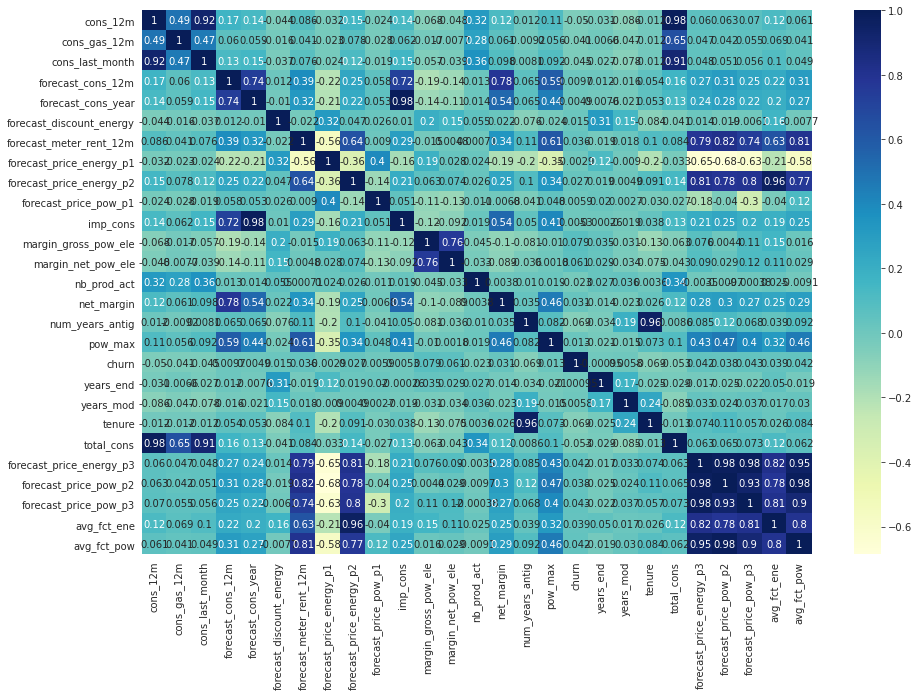

In [295]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),cmap="YlGnBu",annot=True)

From the above, we can conclude that new features related to forecast are highly correlated with themselves, for that reason we are going to delete those features and only take into account the average forecast.

## Grouping Categories

Let's explore categorical data and discover how we can handle it.

In [296]:
#Extract categorical features

categorical=[feature for feature in df.columns if df[feature].dtype =='object' and feature!='id']
print(categorical)

for i in categorical:
  print(df[i].value_counts())
  print('===='*10)

['activity_new', 'channel_sales', 'has_gas', 'origin_up']
apdekpcbwosbxepsfxclislboipuxpop    1528
kkklcdamwfafdcfwofuscwfwadblfmce     420
kwuslieomapmswolewpobpplkaooaaew     226
fmwdwsxillemwbbwelxsampiuwwpcdcb     214
ckfxocssowaeipxueikxcmaxdmcduxsa     186
                                    ... 
bcsfemospxbiwoudpemmseeckfcpwfwu       1
fcokoocmubsiclsbbefulmfiplksskbf       1
opemwsspmskladcbclpkmilallxmiook       1
xumuokeiidieboawuxkidxufcexecbbl       1
cmdfecexccsmowuoksewsukfcwlplamd       1
Name: activity_new, Length: 417, dtype: int64
foosdfpfkusacimwkcsosbicdxkicaua    7113
lmkebamcaaclubfxadlmueccxoimlema    2038
usilxuppasemubllopkaafesmlibmsdf    1412
ewpakwlliwisiwduibdlfmalxowmwpci     943
sddiedcslfslkckwlfkdpoeeailfpeds      10
epumfxlbckeskwekxbiuasklxalciiuu       4
Name: channel_sales, dtype: int64
f    12796
t     2878
Name: has_gas, dtype: int64
lxidpiddsbxsbosboudacockeimpuepw    7590
kamkkxfxxuwbdslkwifmmcsiusiuosws    4489
ldkssxwpmemidmecebumciepifcamkci 

In [297]:
df[categorical].isna().sum()

activity_new     9305
channel_sales    4154
has_gas             0
origin_up           0
dtype: int64

Based on the previuos results we can see that is not necessary to group categorical data. The action we are going to take with feature ```channel_sales``` is to replace missing values with category ```other```

In [298]:
#Replacing NaN in channel_sales with 'other'

df.channel_sales.fillna('other',inplace=True)


## Extracting dates

In the previous EDA we saw that dates, months and years don't show that churn has an specific trend, for that reason, we created features based on dates previously.

In [299]:
df['date_end_qtr']=df['date_end'].dt.month

In [300]:
df.date_end_qtr.replace({1:'Q1',
                                            2:'Q1',
                                            3:'Q1',
                                            4:'Q2',
                                            5:'Q2',
                                            6:'Q2',
                                            7:'Q3',
                                            8:'Q3',
                                            9:'Q3',
                                            10:'Q4',
                                            11:'Q4',
                                            12:'Q4',
},inplace=True)

In [301]:
df.date_end_qtr.value_counts()

Q4    4439
Q1    3922
Q3    3666
Q2    3647
Name: date_end_qtr, dtype: int64

In [302]:

#Variables to delete

to_drop=['date_end','date_renewal','date_modif_prod','date_activ','forecast_price_energy_p2','forecast_price_energy_p3',
         'forecast_price_pow_p2','forecast_price_pow_p3']


df.drop(columns=to_drop,index=1,inplace=True)


# **Transformations**

Our data is highly skewed to the right, let's see our features againd to transform the data.

In [303]:
def plotting_numerical(data,rows,cols,x_list,size):
  '''Plot numerical data in subplots using Seaborn
    Parameters
    --------------
      data:Data frame with data
      rows:Number of rows in subplot
      cols:Number of columns in subplot
      x_list:List with features names
      size:Tupple with size of plot
    
  '''
  
  sns.set_style("whitegrid")

  pos=0
  f, axes = plt.subplots(nrows=rows, ncols=cols,figsize=size)
  for i in range(0,rows):
    for j in range(0,cols):
      
      sns.histplot(data=data,ax=axes[i,j],x=x_list[pos],bins=50)
      pos+=1

  return(plt.show())

In [304]:
numeric=[feature for feature in df.columns if df[feature].dtype =='int64' or df[feature].dtype=='float64' ]
len(numeric)

23

IndexError: ignored

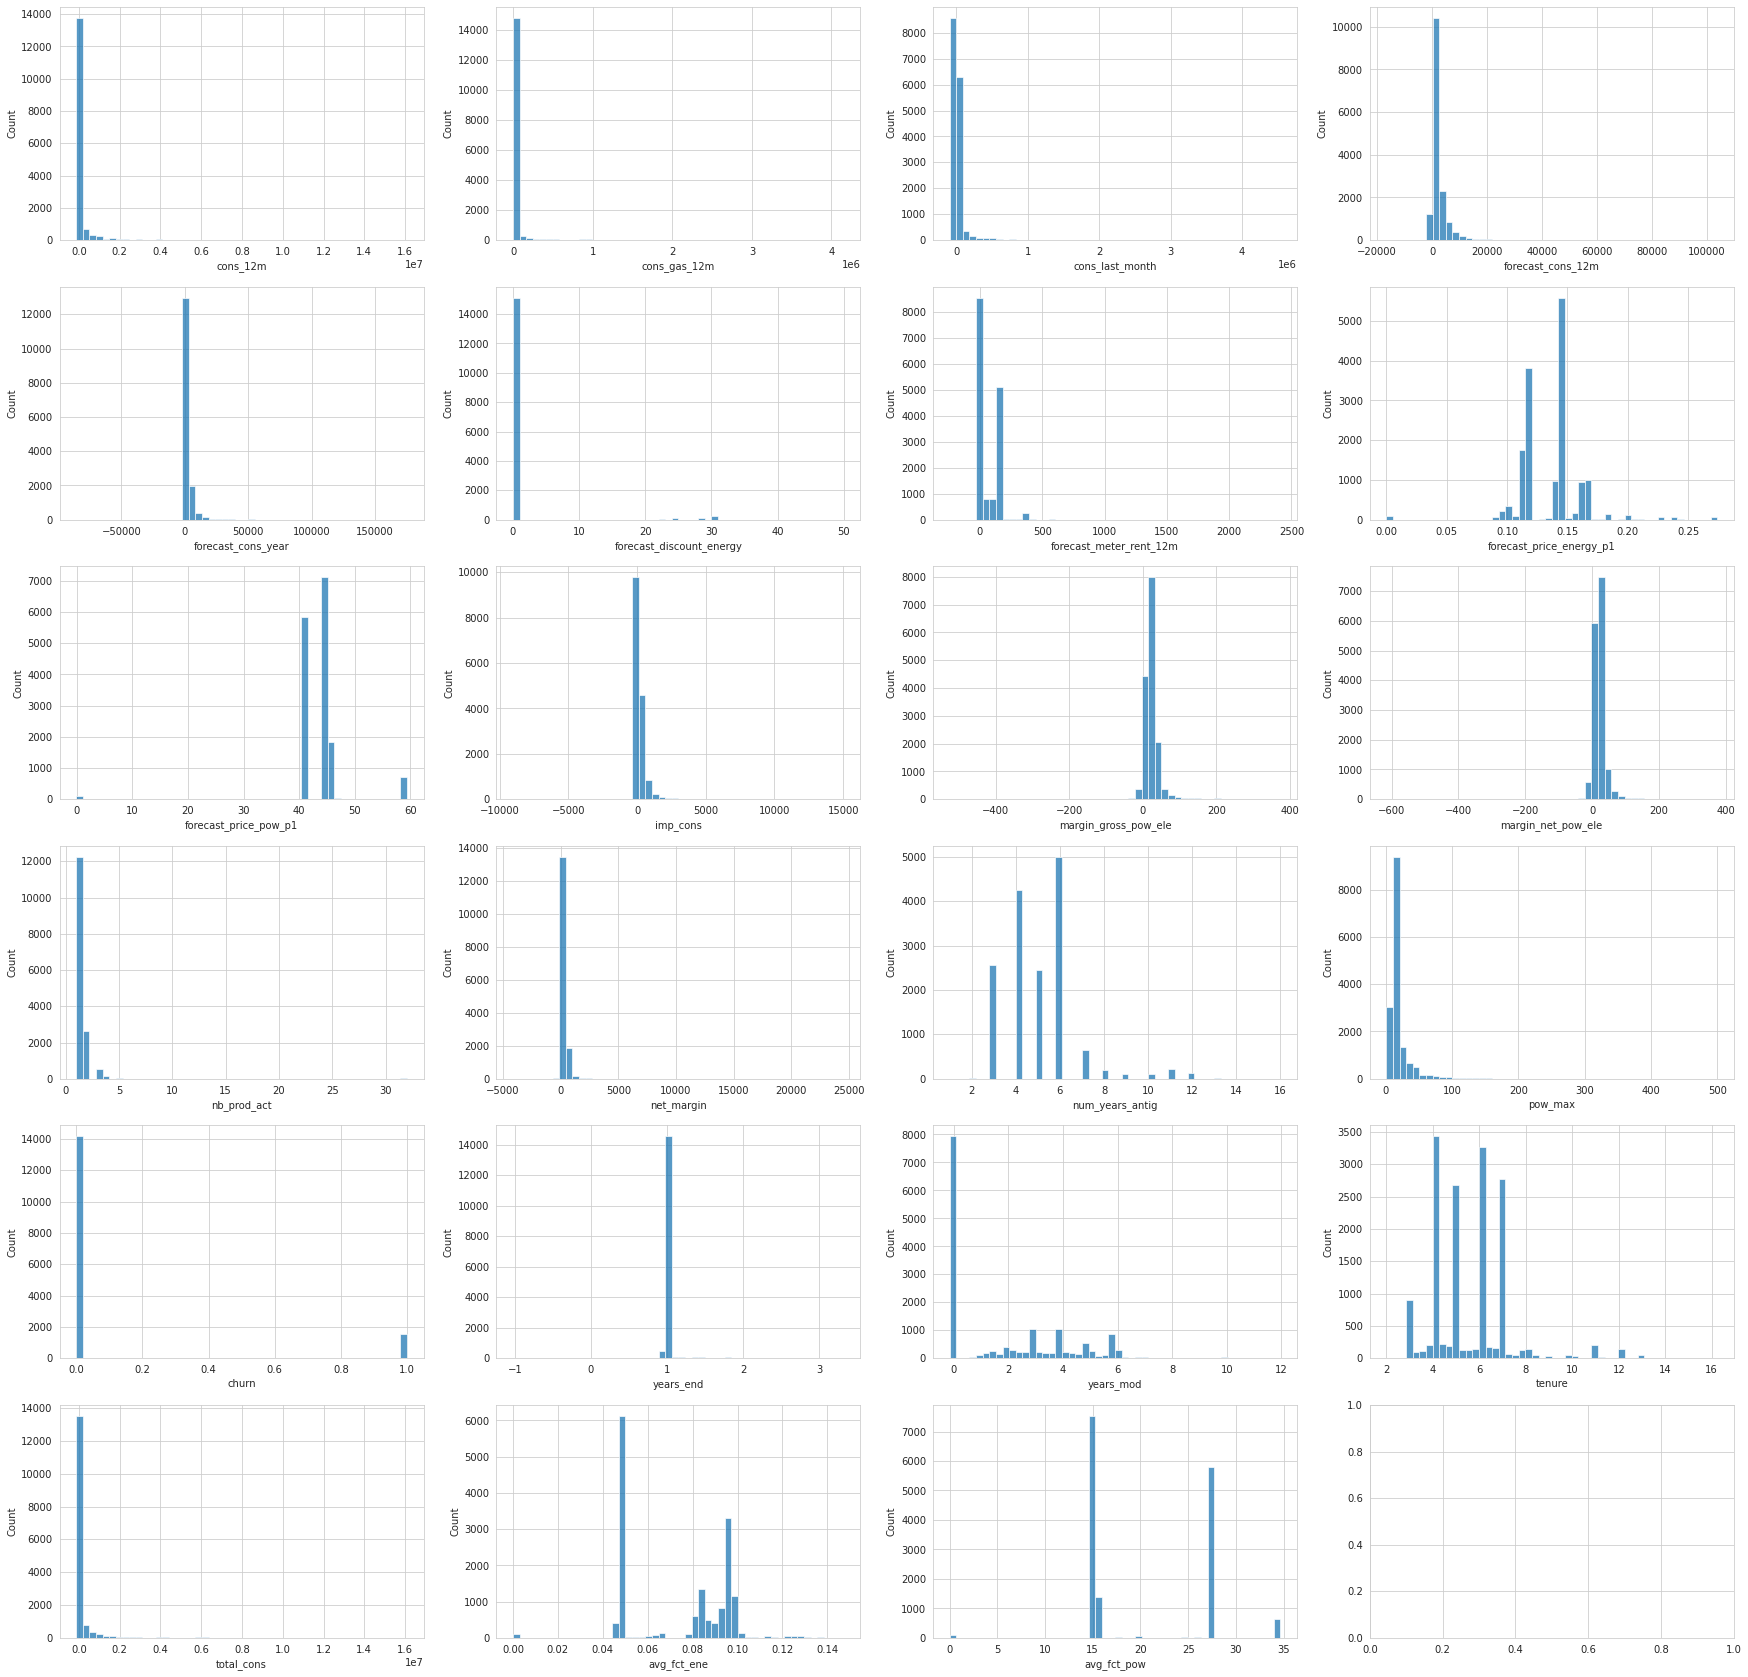

In [305]:
plotting_numerical(df,6,4,numeric,(30,30))

Now, we are going to explore possible corrupted data

In [306]:
#Identifying negative data

negative=[]
for i in numeric:
  negative.append(df[df[i]<0].shape[0])


neg=pd.DataFrame({'negative_data':negative},index=numeric)
neg


,negative_data
cons_12m,25
cons_gas_12m,5
cons_last_month,42
forecast_cons_12m,38
forecast_cons_year,25
forecast_discount_energy,0
forecast_meter_rent_12m,4
forecast_price_energy_p1,0
forecast_price_pow_p1,1
imp_cons,27


From the above, we can see that it's Ok when margings have negative data because it shows that a customer is not profitable for the company. On the other hand, the remaining features have a small number of negative data, we are going to replace negative data with the mean of every feature

In [307]:
#First, replace negative by NaN

to_nan=['cons_12m',
 'cons_gas_12m',
 'cons_last_month',
 'forecast_cons_12m',
 'forecast_cons_year','imp_cons','forecast_meter_rent_12m',
 'years_end','total_cons','forecast_price_pow_p1','years_mod']

 
for i in to_nan:
   df.loc[df[i]<0,i]=np.nan


#Second, calculate the mean
means=[]

for i in to_nan:
  means.append(df[i].mean())


#Third, replace NaN with means

for i,j in zip(to_nan,range(0,11)):
  df[i]=df[i].fillna(means[j])


Now that we don't have negative data, we proceed to transform data

In [308]:
to_transform=['cons_12m',
 'cons_gas_12m',
 'cons_last_month',
 'forecast_cons_12m',
 'forecast_cons_year','imp_cons',
 'years_end','total_cons','forecast_price_pow_p1','years_mod']

df[to_transform]=np.log1p(df[to_transform])


Let's visualize the data after transformation

IndexError: ignored

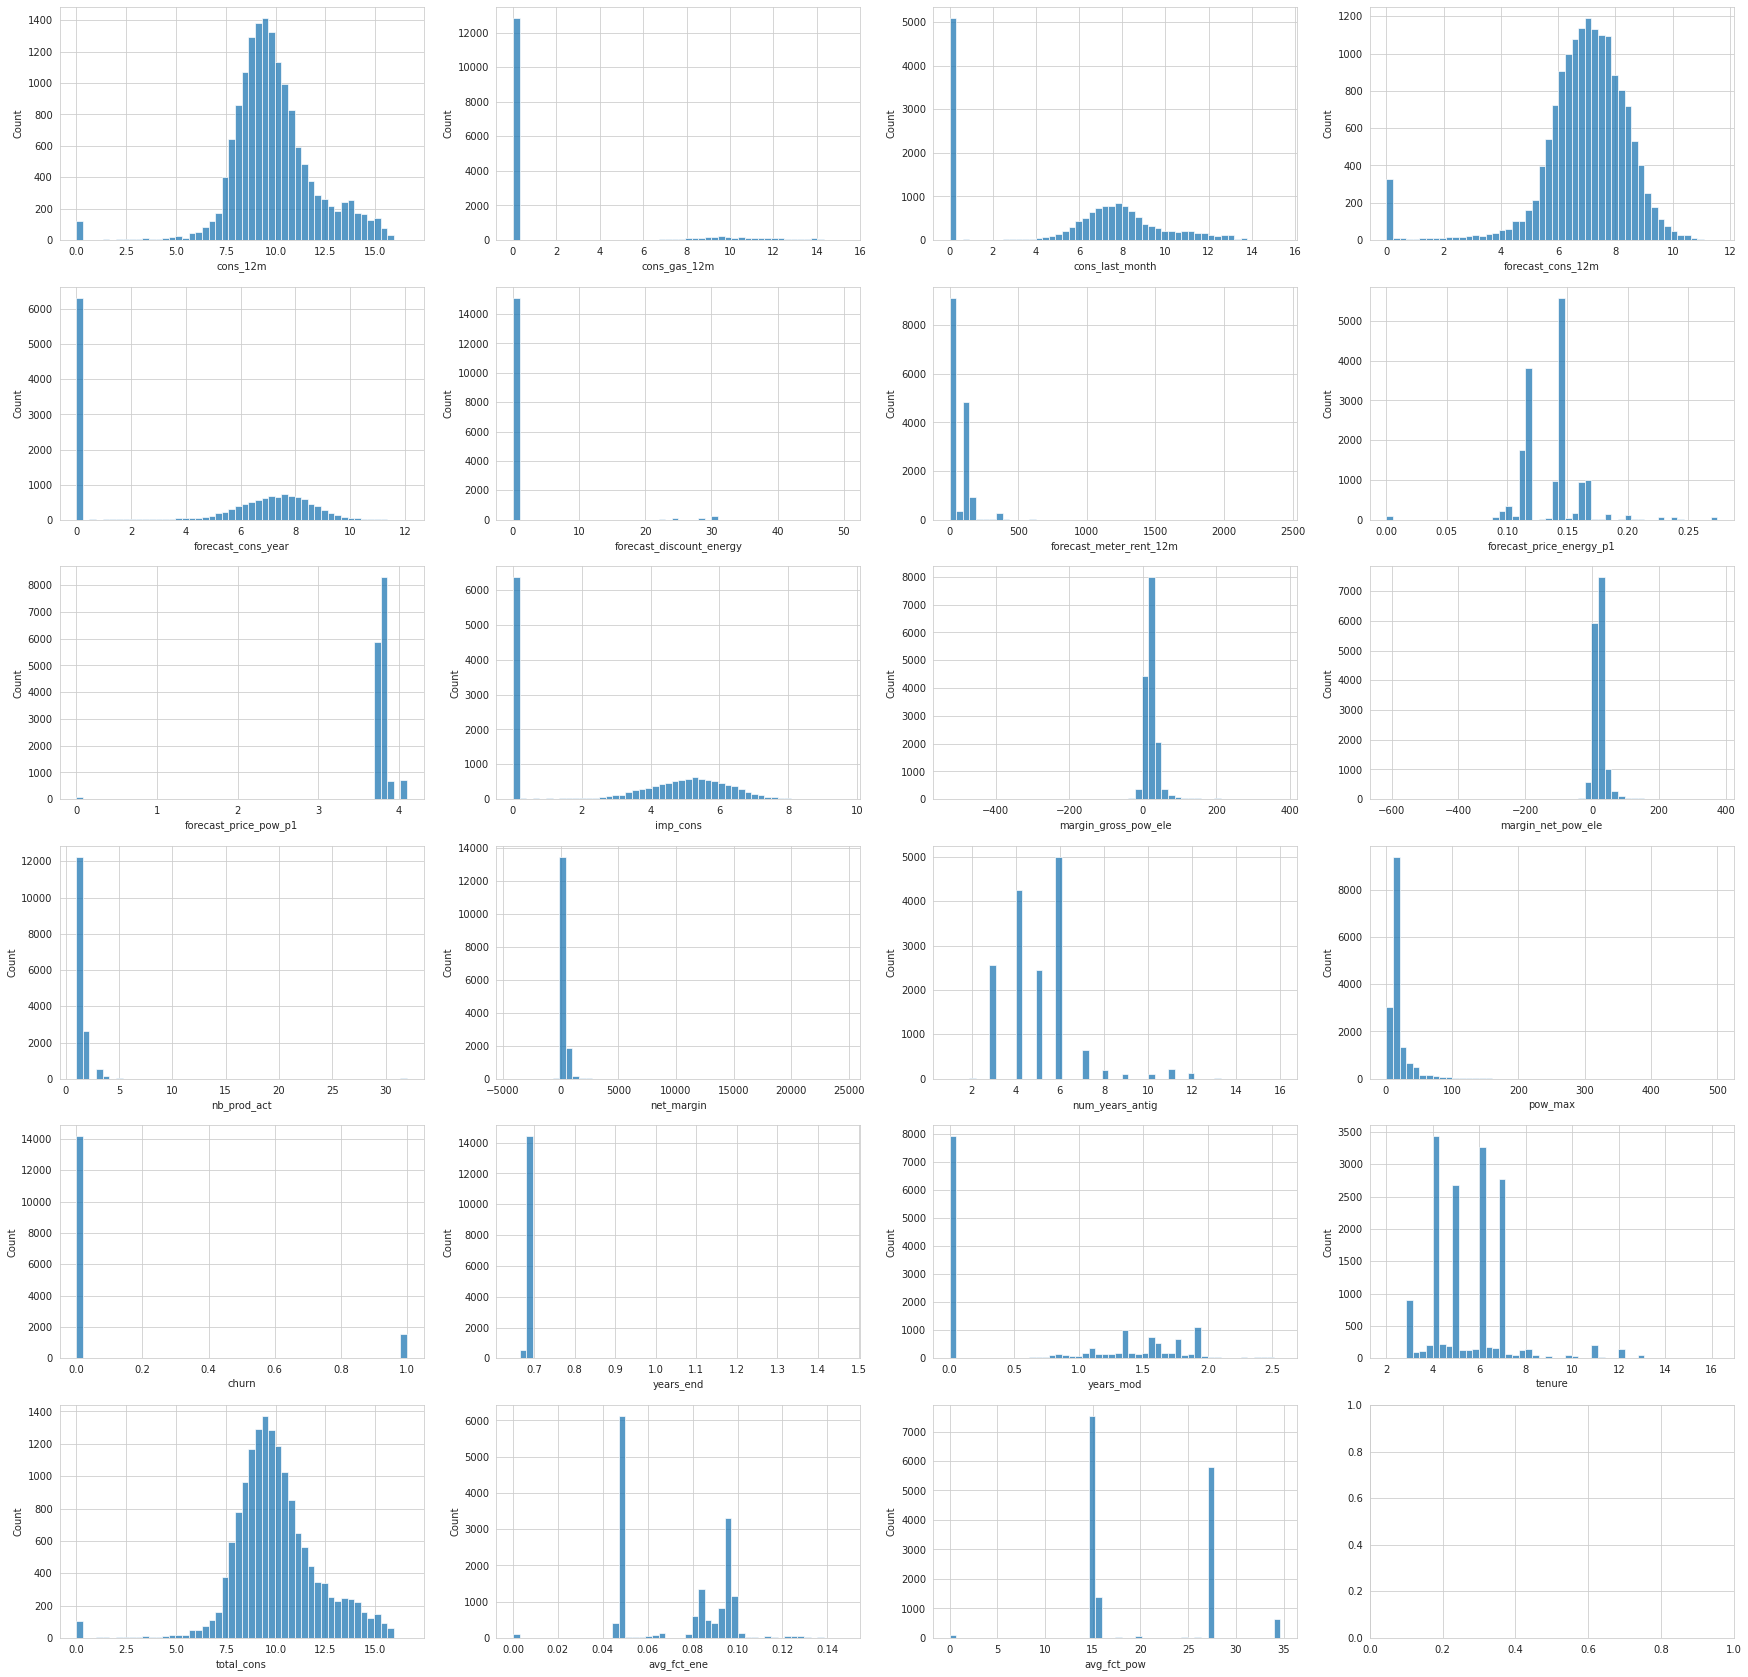

In [309]:
plotting_numerical(df,6,4,numeric,(30,30))

# **2. Split data into Train and Test (customer data)**

This is very important to do before any kind of actions with data liker transformations, outlier detection, etc.

Transformations, scaling, outlier detection must be fit or perform in train set and then in test set we should tranform test data based on the results of train data.

Before moving with Splitting we are going to delete the feature ```activity_new``` because it has almost 60% of missing data.

In [310]:
#Drop activity_new

df.drop(columns='activity_new',inplace=True)

In [311]:
#Getting X and y

features=[x for x in df.columns if x not in ['id','churn']]
X=df.loc[:,features]
y=df[['churn']]

#Getting Dummy variables

X=pd.get_dummies(X,drop_first=True)

#Split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# **3. Outlier detection**

Based on EDA, we saw that almost all the numeric features were quite skwed,so, we have have remove outlier to ensure the best performance while modeling.

In [312]:
#Extract numeric features

numeric=[feature for feature in X.columns if X[feature].dtype =='int64' or X[feature].dtype=='float64' ]
numeric


['cons_12m',
 'cons_gas_12m',
 'cons_last_month',
 'forecast_cons_12m',
 'forecast_cons_year',
 'forecast_discount_energy',
 'forecast_meter_rent_12m',
 'forecast_price_energy_p1',
 'forecast_price_pow_p1',
 'imp_cons',
 'margin_gross_pow_ele',
 'margin_net_pow_ele',
 'nb_prod_act',
 'net_margin',
 'num_years_antig',
 'pow_max',
 'years_end',
 'years_mod',
 'tenure',
 'total_cons',
 'avg_fct_ene',
 'avg_fct_pow']

We can conclude from the EDA that the variables related to consumption and forecast are highly skewed to the right, for that reason, we are going to calculate thresholds for every numeric feature with percentiles 0.001 and 0.999



In [313]:
#Extracting percentiles

lower=[]
for i in numeric:
  lower.append(X_train[i].quantile(0.01))

upper=[]

for i in numeric:
  upper.append(X_train[i].quantile(0.99))

print(lower)
print(upper)

#Save X shape
X_shape=X_train.shape
print(X_shape)  

[3.2076696321871543, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.092453, 3.728261236025718, 0.0, -11.185199999999998, -15.4578, 1.0, 0.0, 3.0, 10.307400000000001, 0.6737828133781542, 0.0, 3.0, 4.39898908893141, 0.04610166666666666, 14.77045932]
[15.183147191140531, 13.75394680780483, 13.05880783964692, 9.786691088032228, 9.846076165461065, 30.0, 359.25, 0.22927199999999998, 4.094277092612744, 7.536165632753255, 109.66469999999944, 104.8355999999999, 4.0, 1314.1483999999955, 11.0, 100.0, 1.0428677539025513, 2.3603369380248056, 12.008219178082191, 15.413483097586102, 0.12289311143939383, 34.608155466666666]
(12538, 36)


In [314]:
X_train.shape

(12538, 36)

In [315]:
X_train['Z_score']=(X_train['cons_12m']-X_train['cons_12m'].mean())/X_train['cons_12m'].std()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [316]:
X_train[(X_train['Z_score']>3) & (X_train['Z_score']<-3)].shape[0]

0

In [317]:
X_train.drop(columns='Z_score',inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [318]:
#Defining a function to replace outliers with mean

def modify_outliers_mean(data,features):

  '''
  This function modifies outliers with mean.
  First, the function detects outliers with Z-score, then calculates the mean of
  the feature without outliers,and finally, replaces outliers with the calculated
  mean.

  Parameters:
  -------------------

  data: dataset to be analyzed
  features: List of numerical features in the dataset

  '''

  to_del=[]
  for i in features:

    #Initialize null lists
    ind_upper=[]
    ind_lower=[]
    ind=[]

    #Calculate Z score
    data['Z_score']=(data[i]-data[i].mean())/data[i].std()
    print(data[(data['Z_score']>3) | (data['Z_score']<-3)].shape[0],' outliers detected for ',i)
    to_del.append(data[(data['Z_score']>3) | (data['Z_score']<-3)].shape[0])
    
    #Identified outliers
    ind=data[(data['Z_score']>3) | (data['Z_score']<-3)].index
    
    #Calculate mean to replace outlier

    mean_to_replace=data[(data['Z_score']<3) & (data['Z_score']>-3)][i].mean()
    
    #Replacing outliers
    data.loc[ind,i]=mean_to_replace

  print('total outliers modified: ',sum(to_del))
  data.drop(columns='Z_score',inplace=True)


In [321]:
modify_outliers_mean(X_train,numeric)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

137  outliers detected for  cons_12m
95  outliers detected for  cons_gas_12m
0  outliers detected for  cons_last_month
313  outliers detected for  forecast_cons_12m
0  outliers detected for  forecast_cons_year
435  outliers detected for  forecast_discount_energy
288  outliers detected for  forecast_meter_rent_12m
219  outliers detected for  forecast_price_energy_p1
72  outliers detected for  forecast_price_pow_p1
0  outliers detected for  imp_cons
186  outliers detected for  margin_gross_pow_ele
174  outliers detected for  margin_net_pow_ele
52  outliers detected for  nb_prod_act
184  outliers detected for  net_margin
299  outliers detected for  num_years_antig
231  outliers detected for  pow_max
330  outliers detected for  years_end
0  outliers detected for  years_mod
367  outliers detected for  tenure
118  outliers detected for  total_cons
70  outliers detected for  avg_fct_ene
69  outliers detected for  avg_fct_pow
total outliers modified:  3639


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [319]:
'''

#Removing outliers


for feature,low,up in zip(numeric,lower,upper):
 #print(feature,low,up)
 X_train=X_train[(X_train[feature]<=up)&(X_train[feature]>=low)]
 #print(algo.shape)

#New Shape of X_train
print(X_train.shape)

index=X_train.index
y_train=y_train.loc[index,:]

print(y_train.shape)
'''

'\n\n#Removing outliers\n\n\nfor feature,low,up in zip(numeric,lower,upper):\n #print(feature,low,up)\n X_train=X_train[(X_train[feature]<=up)&(X_train[feature]>=low)]\n #print(algo.shape)\n\n#New Shape of X_train\nprint(X_train.shape)\n\nindex=X_train.index\ny_train=y_train.loc[index,:]\n\nprint(y_train.shape)\n'

# **Export datasets**

In [322]:
X_train.to_csv('/content/drive/MyDrive/Colab Notebooks/BCG/X_train.csv',index=False)
X_test.to_csv('/content/drive/MyDrive/Colab Notebooks/BCG/X_test.csv',index=False)
y_train.to_csv('/content/drive/MyDrive/Colab Notebooks/BCG/y_train.csv',index=False)
y_test.to_csv('/content/drive/MyDrive/Colab Notebooks/BCG/y_test.csv',index=False)